# Dimensionality reduction and visualization with polarity based color-coding Using TSNE

In this notebook we will do dimensionality reduction and visualization using TSNE over 'Text_type data' named Amazon Fine Food reviews . In the process we will explore some of the interesting text featurization techniques of NLP like bag of words, TF-IDF, Avg Word2Vec, TF-IDF Word2vec, Glove etc.

**Overview of Data**

This dataset consists of reviews of fine foods (food products) from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories.<br>

Data Source : https://snap.stanford.edu/data/web-FineFoods.html or https://www.kaggle.com/snap/amazon-fine-food-reviews (not using the updated one, using the old one here from the Stanford website)

Paper reference : http://i.stanford.edu/~julian/pdfs/recsys13.pdf

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012 (13 years)<br> 
Number of Attributes/Columns in data: 10<br>

Attribute Information:<br>

>1.Id<br>

>2.ProductId - unique identifier for the product<br>

>3.UserId - unqiue identifier for the user<br>

>4.ProfileName<br>

>5.HelpfulnessNumerator - number of users who found the review     helpful<br>

>6.HelpfulnessDenominator - number of users who indicated whether they<br> found the review helpful or not<br>

>7.Score - rating between 1 and 5<br>

>8.Time - timestamp for the review<br>

>9.Summary - brief summary of the review<br>

>10.Text - text of the review<br>

**Machine Learning Problem Statement**<br>

This is a Typical Sentiment Analysis Binary classification machine learning problem. We still don't know if the data is balanced or imbalanced over class.We have to do EDA to find that out. 

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

**Loading the Data**

The dataset is available in two forms

>    1) .csv file<br>
>    2) SQLite Database<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
# Some required library imports 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
!python -m pip install -U gensim

Requirement already up-to-date: gensim in d:\coding\locker\pysoftwares\lib\site-packages (3.8.3)


In [4]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

**Reading Data**

In [5]:
reviews = pd.read_csv("C:\\Users\\User\\Desktop\\reviews.csv" )
reviews.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [7]:
# Give reviews with Score > 3 a positive rating, and reviews with a score < 3 a negative rating.

def partition(x):
    if x<3:
        return 0
    return 1

actualscore = reviews['Score']
newscores = actualscore.map(partition)
reviews['Score'] = newscores
print('number of data points in data',reviews.shape)
reviews.head(25)

number of data points in data (568454, 10)


Id   ProductId          UserId                      ProfileName  \
0    1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1    2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2    3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3    4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4    5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
5    6  B006K2ZZ7K   ADT0SRK1MGOEU                   Twoapennything   
6    7  B006K2ZZ7K  A1SP2KVKFXXRU1                David C. Sullivan   
7    8  B006K2ZZ7K  A3JRGQVEQN31IQ               Pamela G. Williams   
8    9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
9   10  B00171APVA  A21BT40VZCCYT4                    Carol A. Reed   
10  11  B0001PB9FE  A3HDKO7OW0QNK4                     Canadian Fan   
11  12  B0009XLVG0  A2725IB4YY9JEB           A Poeng "SparkyGoHome"   
12  13  B0009XLVG0   A327PCT23YH90                               LT   
13  14  B001GVISJM  A18ECVX2RJ7HUE                  willie "roadie"   
14  15  B001GVISJM  A2MUGFV2TDQ47K              Lynrie "Oh HELL no"   
15  16  B001GVISJM  A1CZX3CP8IKQIJ                     Brian A. Lee   
16  17  B001GVISJM  A3KLWF6WQ5BNYO                   Erica Neathery   
17  18  B001GVISJM   AFKW14U97Z6QO                            Becca   
18  19  B001GVISJM  A2A9X58G2GTBLP                          Wolfee1   
19  20  B001GVISJM  A3IV7CL2C13K2U                             Greg   
20  21  B001GVISJM  A1WO0KGLPR5PV6                         mom2emma   
21  22  B001GVISJM   AZOF9E17RGZH8                   Tammy Anderson   
22  23  B001GVISJM   ARYVQL4N737A1                    Charles Brown   
23  24  B001GVISJM   AJ613OLZZUG7V                           Mare's   
24  25  B001GVISJM  A22P2J09NJ9HKE      S. Cabanaugh "jilly pepper"   

    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                      1                       1      1  1303862400   
1                      0                       0      0  1346976000   
2                      1                       1      1  1219017600   
3                      3                       3      0  1307923200   
4                      0                       0      1  1350777600   
5                      0                       0      1  1342051200   
6                      0                       0      1  1340150400   
7                      0                       0      1  1336003200   
8                      1                       1      1  1322006400   
9                      0                       0      1  1351209600   
10                     1                       1      1  1107820800   
11                     4                       4      1  1282867200   
12                     1                       1      0  1339545600   
13                     2                       2      1  1288915200   
14                     4                       5      1  1268352000   
15                     4                       5      1  1262044800   
16                     0                       0      0  1348099200   
17                     0                       0      1  1345075200   
18                     0                       0      1  1324598400   
19                     0                       0      1  1318032000   
20                     0                       0      1  1313452800   
21                     0                       0      1  1308960000   
22                     0                       0      1  1304899200   
23                     0                       0      1  1304467200   
24                     0                       0      1  1295481600   

                                              Summary  \
0                               Good Quality Dog Food   
1                                   Not as Advertised   
2                               "Delight" says it all   
3                                      Cough Medicine   
4                        

**Grouping Data by Score**

In [8]:
v = reviews.groupby('Score').size().reset_index(name = 'count')
grpbyscore = pd.DataFrame(v)
grpbyscore

Score   count
0      0   82037
1      1  486417

**Data Cleaning : Deduplication**

Data Cleaning is an extremely important aspect in real world Machine Learning. Any Machine Learning system you design is not a God by itself. It simply obeys the universal rule of **"Garbage in - Garbage out**"

The data is imbalanced.

**Grouping Data by unique User ID**

In [9]:
mp = pd.DataFrame(reviews)
mp

Id   ProductId          UserId                      ProfileName  \
0            1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1            2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2            3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3            4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4            5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...        ...         ...             ...                              ...   
568449  568450  B001EO7N10  A28KG5XORO54AY                 Lettie D. Carter   
568450  568451  B003S1WTCU  A3I8AFVPEE8KI5                        R. Sawyer   
568451  568452  B004I613EE  A121AA1GQV751Z                    pksd "pk_007"   
568452  568453  B004I613EE   A3IBEVCTXKNOH          Kathy A. Welch "katwel"   
568453  568454  B001LR2CU2  A3LGQPJCZVL9UC                         srfell17   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                          1                       1      1  1303862400   
1                          0                       0      0  1346976000   
2                          1                       1      1  1219017600   
3                          3                       3      0  1307923200   
4                          0                       0      1  1350777600   
...                      ...                     ...    ...         ...   
568449                     0                       0      1  1299628800   
568450                     0                       0      0  1331251200   
568451                     2                       2      1  1329782400   
568452                     1                       1      1  1331596800   
568453                     0                       0      1  1338422400   

                                   Summary  \
0                    Good Quality Dog Food   
1                        Not as Advertised   
2                    "Delight" says it all   
3                           Cough Medicine   
4                              Great taffy   
...                                    ...   
568449                 Will not do without   
568450                        disappointed   
568451            Perfect for our maltipoo   
568452  Favorite Training and reward treat   
568453                         Great Honey   

                                                     Text  
0       I have bought several of the Vitality canned d...  
1       Product arrived labeled as Jumbo Salted Peanut...  
2       This is a confection that has been around a fe...  
3       If you are looking for the secret ingredient i...  
4       Great taffy at a great price.  There was a wid...  
...                                                   ...  
568449  Great for sesame chicken..this is a good if no...  
568450  I'm disappointed with the flavor. The chocolat...  
568451  These stars are small, so you can give 10-15 o...  
568452  These are the BEST treats for training and rew...  
568453  I am very satisfied ,product is as advertised,...  

[568454 rows x 10 columns]

**How many unique users are present?**

In [10]:
k = mp.groupby('UserId').size().reset_index(name = 'count')
grpbyuserid = pd.DataFrame(k)
grpbyuserid

UserId  count
0       #oc-R103C0QSV1DF5E      1
1       #oc-R109MU5OBBZ59U      1
2       #oc-R10LFEMQEW6QGZ      1
3       #oc-R10LT57ZGIB140      1
4       #oc-R10UA029WVWIUI      1
...                    ...    ...
256054       AZZV9PDNMCOZW      3
256055       AZZVNIMTTMJH6      1
256056       AZZY649VYAHQS      1
256057       AZZYCJOJLUDYR      1
256058       AZZZOVIBXHGDR      1

[256059 rows x 2 columns]

How many users are exist more than once ? 

In [11]:
v = grpbyuserid[grpbyuserid['count'] >1]
v

UserId  count
5       #oc-R115TNMSPFT9I7      2
7       #oc-R11D9D7SHXIJB9      3
9       #oc-R11DNU2NBKQ23Z      2
10      #oc-R11O5J5ZVQE25C      3
14      #oc-R12KPBODL2B5ZD      2
...                    ...    ...
256039       AZZNK89PXD006      6
256048       AZZTH6DJ0KSIP      3
256049       AZZU1VEO8KUXH      3
256050       AZZU4D6TZ2L6J      2
256054       AZZV9PDNMCOZW      3

[80668 rows x 2 columns]

In [12]:
v['count'].sum()

393063

What's the maximum number of times a user has been repeated ?

In [13]:
v['count'].max()

448

Are the productIds also repeated for all the 448 repeated UserId?

In [14]:
v[v['count'] == 448]

UserId  count
182011  A3OXHLG6DIBRW8    448

In [15]:
ac = mp[mp['UserId'] == 'A3OXHLG6DIBRW8']
ac

Id   ProductId          UserId       ProfileName  \
369        370  B002O3VHXU  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
813        814  B004ET7MG8  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3306      3307  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3416      3417  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3926      3927  B000VSDFRG  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
...        ...         ...             ...               ...   
562279  562280  B004HOSGWE  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
563973  563974  B001XSMANI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
564414  564415  B001D3LUP2  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
567686  567687  B005K4Q68Q  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
567796  567797  B005K4Q68Q  A3OXHLG6DIBRW8  C. F. Hill "CFH"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
369                        1                       1      1  1282176000   
813                        3                       4      0  1272240000   
3306                      24                      25      1  1321401600   
3416                       5                       5      1  1321401600   
3926                       2                       2      1  1237161600   
...                      ...                     ...    ...         ...   
562279                     1                       1      1  1329609600   
563973                     3                       4      1  1279411200   
564414                     2                       2      1  1243209600   
567686                    24                      25      1  1321401600   
567796                     5                       5      1  1321401600   

                                                  Summary  \
369               Very Smooth Coffee - Highly Recommended   
813                     Odd Fake Flavor - Not Recommended   
3306           Really Good Hot Cocoa - Highly Recommended   
3416           Really Good Hot Cocoa - Highly Recommended   
3926    Great Diabetic Friendly Candy - Highly Recomme...   
...                                                   ...   
562279             Great Spicy Snack - Highly Recommended   
563973  Great Tasting and a Great Value - Highly Recom...   
564414  Good Tasting Sugarfree Gum - Flavor Tapers Off...   
567686         Really Good Hot Cocoa - Highly Recommended   
567796         Really Good Hot Cocoa - Highly Recommended   

                                                     Text  
369     Green Mountain "Nantucket Blend" K-Cups make a...  
813     Trident "Strawberry Twist" sugarless gum is ve...  
3306    These Grove Square Hot Cocoa flavors are by fa...  
3416    These Grove Square Hot Cocoa flavors are by fa...  
3926    Hershey "Sugar Free Caramel Filled Chocolates"...  
...                                                   ...  
562279  The Blue Diamond Jalapeno Smokehouse Almonds a...  
563973  Kirkland Jelly Beans are a great value and all...  
564414  Wrigley's  Elixir Gum is good tasting, but onl...  
567686  These Grove Square Hot Cocoa flavors are by fa...  
567796  These Grove Square Hot Cocoa flavors are by fa...  

[448 rows x 10 columns]

The productIds have not been repeated for the same userId. Hence, there is a considerable chance all repeated Userids need not have repeated ProductIds as well. <br>

May be , the same user is buying different products on amazon. This possibility has to be considered by us.<br>

UserIds are not being repeated for the same product Ids<br>

But, There may exist repeated some user Ids for which the product Ids are also being repeated. They are duplicates of data and lets detect below if they are existing or not ----------

It has been observed from above that users are being repeated. But the real question is are the usersIds repeated for the same products ? <br>

Is there real duplication in rows in the above data frame ?

In [16]:
o = mp.groupby(['UserId','ProductId']).size().reset_index(name = 'count')
grpbyuseridandproductid = pd.DataFrame(o)
grpbyuseridandproductid

UserId   ProductId  count
0       #oc-R103C0QSV1DF5E  B006Q820X0      1
1       #oc-R109MU5OBBZ59U  B008I1XPKA      1
2       #oc-R10LFEMQEW6QGZ  B008I1XPKA      1
3       #oc-R10LT57ZGIB140  B0026LJ3EA      1
4       #oc-R10UA029WVWIUI  B006Q820X0      1
...                    ...         ...    ...
560799       AZZV9PDNMCOZW  B003SNX4YA      1
560800       AZZVNIMTTMJH6  B000FI4O90      1
560801       AZZY649VYAHQS  B000N9VLJ2      1
560802       AZZYCJOJLUDYR  B001SB22UG      1
560803       AZZZOVIBXHGDR  B001EO5SB2      1

[560804 rows x 3 columns]

In [17]:
lm = grpbyuseridandproductid[grpbyuseridandproductid['count'] > 1]
lm

UserId   ProductId  count
1148    A102TGNH1D915Z  B00008DFK5      2
1149    A102TGNH1D915Z  B0002DHNXC      2
1150    A102TGNH1D915Z  B0009YD7P2      2
1152    A102TGNH1D915Z  B000SP1CWW      2
1631    A106N4B4EG4DR8  B0008IT4OM      2
...                ...         ...    ...
560678   AZYMD9P9F9UZ6  B000GW46DE      3
560679   AZYMD9P9F9UZ6  B000GW6786      3
560680   AZYMD9P9F9UZ6  B000PMC7GI      3
560681   AZYMD9P9F9UZ6  B000PMHLZK      3
560682   AZYMD9P9F9UZ6  B000PMJLJO      3

[5859 rows x 3 columns]

In [18]:
grpbyuseridandproductid[grpbyuseridandproductid['count'] > 10]

UserId   ProductId  count
186174  A29JUMRL1US6YP  B000084EZ4     11
186175  A29JUMRL1US6YP  B00008CQVA     11
186195  A29JUMRL1US6YP  B000WFEN74     11
186196  A29JUMRL1US6YP  B000WFKI82     11
186197  A29JUMRL1US6YP  B000WFKWDI     11
186198  A29JUMRL1US6YP  B000WFN0VO     11
186199  A29JUMRL1US6YP  B000WFORH0     11
186200  A29JUMRL1US6YP  B000WFPJIG     11
186201  A29JUMRL1US6YP  B000WFRQQ4     11
186202  A29JUMRL1US6YP  B000WFU8O6     11
186203  A29JUMRL1US6YP  B000WFUL3E     11

**At max how many repitions have occured?**

In [19]:
grpbyuseridandproductid['count'].max()

11

From the above we can notice that there are duplicates rows existing in our data. But are they really duplicates? Does repition of user ids along with the repition of corrsponding Product ids imply presence of duplicate rows? <br> answer is **Yes**

But the real question we have to ask is , are non-repeting productIds for the same user, refering to the same product on amazon.com or different products? <br>

Is presence of  different product Ids enough to conclude that the products are different ?

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [20]:
ac = mp[mp['UserId'] == 'A3OXHLG6DIBRW8']
ac

Id   ProductId          UserId       ProfileName  \
369        370  B002O3VHXU  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
813        814  B004ET7MG8  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3306      3307  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3416      3417  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3926      3927  B000VSDFRG  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
...        ...         ...             ...               ...   
562279  562280  B004HOSGWE  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
563973  563974  B001XSMANI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
564414  564415  B001D3LUP2  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
567686  567687  B005K4Q68Q  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
567796  567797  B005K4Q68Q  A3OXHLG6DIBRW8  C. F. Hill "CFH"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
369                        1                       1      1  1282176000   
813                        3                       4      0  1272240000   
3306                      24                      25      1  1321401600   
3416                       5                       5      1  1321401600   
3926                       2                       2      1  1237161600   
...                      ...                     ...    ...         ...   
562279                     1                       1      1  1329609600   
563973                     3                       4      1  1279411200   
564414                     2                       2      1  1243209600   
567686                    24                      25      1  1321401600   
567796                     5                       5      1  1321401600   

                                                  Summary  \
369               Very Smooth Coffee - Highly Recommended   
813                     Odd Fake Flavor - Not Recommended   
3306           Really Good Hot Cocoa - Highly Recommended   
3416           Really Good Hot Cocoa - Highly Recommended   
3926    Great Diabetic Friendly Candy - Highly Recomme...   
...                                                   ...   
562279             Great Spicy Snack - Highly Recommended   
563973  Great Tasting and a Great Value - Highly Recom...   
564414  Good Tasting Sugarfree Gum - Flavor Tapers Off...   
567686         Really Good Hot Cocoa - Highly Recommended   
567796         Really Good Hot Cocoa - Highly Recommended   

                                                     Text  
369     Green Mountain "Nantucket Blend" K-Cups make a...  
813     Trident "Strawberry Twist" sugarless gum is ve...  
3306    These Grove Square Hot Cocoa flavors are by fa...  
3416    These Grove Square Hot Cocoa flavors are by fa...  
3926    Hershey "Sugar Free Caramel Filled Chocolates"...  
...                                                   ...  
562279  The Blue Diamond Jalapeno Smokehouse Almonds a...  
563973  Kirkland Jelly Beans are a great value and all...  
564414  Wrigley's  Elixir Gum is good tasting, but onl...  
567686  These Grove Square Hot Cocoa flavors are by fa...  
567796  These Grove Square Hot Cocoa flavors are by fa...  

[448 rows x 10 columns]

In [21]:
lk = mp[mp['ProductId'] == 'B005K4Q1VI']
lk

Id   ProductId          UserId            ProfileName  \
3204  3205  B005K4Q1VI  A1BJHZE41QWBX6  Sharon Pipke "Sharon"   
3205  3206  B005K4Q1VI  A365A90ZY1Q80T      Kimberly M. Sholl   
3206  3207  B005K4Q1VI   AQ80LJNDLVZPG              PinkBiker   
3207  3208  B005K4Q1VI  A2NWIF2APZNNV0                    gio   
3208  3209  B005K4Q1VI   A9RIPXAHUQBKY                  Maddy   
...    ...         ...             ...                    ...   
3523  3524  B005K4Q1VI  A2H0LXLB09PYZI                  Sadie   
3524  3525  B005K4Q1VI  A2RHFQS6K0ERIY               L. Segal   
3525  3526  B005K4Q1VI  A16XJ5P33M7S1S                 ellenp   
3526  3527  B005K4Q1VI  A17H97W857Q698      Claudia's hobbies   
3527  3528  B005K4Q1VI  A3LJ6ZJ3MB6NNO              princess1   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
3204                     0                       0      1  1349568000   
3205                     0                       0      1  1349568000   
3206                     0                       0      1  1349481600   
3207                     0                       0      1  1349395200   
3208                     0                       0      1  1348617600   
...                    ...                     ...    ...         ...   
3523                     0                       0      1  1350518400   
3524                     0                       0      1  1350432000   
3525                     0                       0      1  1350345600   
3526                     0                       0      1  1350259200   
3527                     0                       0      0  1349913600   

                                                Summary  \
3204  Grove Square Hot Cocoa Cups, Milk Chocolate, S...   
3205                                Delicious Hot Cocoa   
3206                                          So yummy!   
3207                                              yummy   
3208                                             Great!   
...                                                 ...   
3523                                 Great for winter !   
3524                                   Mmmmmm-Mmm Good!   
3525            Thanks for the best hot cocoa outthere!   
3526                                  good for all ages   
3527                                      hot chocolate   

                                                   Text  
3204  I received the K-cups on time and in execellan...  
3205  This is the best hot cocoa I've had in a K-Cup...  
3206  I'm pregnant and had to,give up my hot cup of ...  
3207  This is quite the buy compared to other hot ch...  
3208  Kids loved it. Great product at a great price....  
...                                                 ...  
3523  I love a cup of Hot Choc. in the cold winter m...  
3524  My daughter says this is the very best hot cho...  
3525  I finally found a hot cocoa for the keurig tha...  
3526  My grandson and husband love to bond drinking ...  
3527  I thought the Grove hot chocolate is to sweet....  

[324 rows x 10 columns]

In [22]:
lk[lk['ProfileName'] == 'C. F. Hill "CFH"']

Id   ProductId          UserId       ProfileName  \
3306  3307  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   
3416  3417  B005K4Q1VI  A3OXHLG6DIBRW8  C. F. Hill "CFH"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
3306                    24                      25      1  1321401600   
3416                     5                       5      1  1321401600   

                                         Summary  \
3306  Really Good Hot Cocoa - Highly Recommended   
3416  Really Good Hot Cocoa - Highly Recommended   

                                                   Text  
3306  These Grove Square Hot Cocoa flavors are by fa...  
3416  These Grove Square Hot Cocoa flavors are by fa...

Like observed above for product Id == 'B005K4Q1V'  and ProfileName == (C. F. Hill "CFH"	), there exists 2 repeated entries, which are mere duplicates of each other . <br>

We have to remove such entries. Similarly ----------------

In [23]:
kv = mp[mp['ProfileName'] == 'Geetha Krishnan']
kv

Id   ProductId         UserId      ProfileName  \
73790    73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan   
78444    78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan   
138276  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan   
138316  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan   
155048  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
73790                      2                       2      1  1199577600   
78444                      2                       2      1  1199577600   
138276                     2                       2      1  1199577600   
138316                     2                       2      1  1199577600   
155048                     2                       2      1  1199577600   

                                  Summary  \
73790   LOACKER QUADRATINI VANILLA WAFERS   
78444   LOACKER QUADRATINI VANILLA WAFERS   
138276  LOACKER QUADRATINI VANILLA WAFERS   
138316  LOACKER QUADRATINI VANILLA WAFERS   
155048  LOACKER QUADRATINI VANILLA WAFERS   

                                                     Text  
73790   DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
78444   DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
138276  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
138316  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
155048  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

We will remove duplicates of entries like above before doing meaningful EDA on our data<br>As can be seen above the same user has multiple reviews with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that : 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

**The method we will be using to remove duplicates is that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.**

In [24]:
#Sorting data according to ProductId in ascending order
sorted_data = mp.sort_values('ProductId',axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')
sorted_data

Id   ProductId          UserId  \
150528  150529  0006641040   A25ACLV5KPB4W   
150506  150507  0006641040  A1S4A3IQ2MU7V4   
150505  150506  0006641040  A2IW4PEEKO2R0U   
150504  150505  0006641040  A2PTSM496CF40Z   
150503  150504  0006641040   AQEYF1AXARWJZ   
...        ...         ...             ...   
191720  191721  B009UOFTUI   AJVB004EB0MVK   
1477      1478  B009UOFU20   AJVB004EB0MVK   
328481  328482  B009UUS05I   ARL20DSHGVM1Y   
5702      5703  B009WSNWC4   AMP7K1O84DH1T   
327600  327601  B009WVB40S  A3ME78KVX31T21   

                                             ProfileName  \
150528                               Matt Hetling "Matt"   
150506                             sally sue "sally sue"   
150505                                             Tracy   
150504  Jason A. Teeple "Nobody made a greater mistak...   
150503                         Les Sinclair "book maven"   
...                                                  ...   
191720                                 D. Christofferson   
1477                                   D. Christofferson   
328481                                             Jamie   
5702                                                ESTY   
327600                                              K'la   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
150528                     0                       1      1  1108425600   
150506                     1                       1      1  1191456000   
150505                     1                       1      1  1194739200   
150504                     1                       1      1  1210809600   
150503                     1                       1      1  1212278400   
...                      ...                     ...    ...         ...   
191720                     0                       0      0  1345852800   
1477                       0                       0      0  1345852800   
328481                     0                       0      1  1331856000   
5702                       0                       0      1  1351209600   
327600                     0                       0      1  1351123200   

                                                  Summary  \
150528                        Nice cadence, catchy rhymes   
150506                      chicken soup with rice months   
150505         Love the book, miss the hard cover version   
150504                                          A classic   
150503                             Chicken Soup with Rice   
...                                                   ...   
191720  weak coffee not good for a premium product and...   
1477    weak coffee not good for a premium product and...   
328481                                            Perfect   
5702                                            DELICIOUS   
327600                                             Tasty!   

                                                     Text  
150528  In June<br />I saw a charming group<br />of ro...  
150506  This is a fun way for children to learn their ...  
150505  I grew up reading these Sendak books, and watc...  
150504  Get the movie or sound track and sing along wi...  
150503  A very entertaining rhyming story--cleaver and...  
...                                                   ...  
191720  This coffee supposedly is premium, it tastes w...  
1477    This coffee supposedly is premium, it tastes w...  
328481  The basket was the perfect sympathy gift when ...  
5702    Purchased this product at a local store in NY ...  
327600  I purchased this to send to my son who's away ...  

[568454 rows x 10 columns]

In [25]:
final_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Summary","HelpfulnessNumerator","HelpfulnessDenominator","Text"}, keep='first', inplace=False)
final_data

Id   ProductId          UserId  \
150528  150529  0006641040   A25ACLV5KPB4W   
150506  150507  0006641040  A1S4A3IQ2MU7V4   
150505  150506  0006641040  A2IW4PEEKO2R0U   
150504  150505  0006641040  A2PTSM496CF40Z   
150503  150504  0006641040   AQEYF1AXARWJZ   
...        ...         ...             ...   
193171  193172  B009RSR8HO  A3JJTHP8T7A8LY   
188388  188389  B009SF0TN6  A1L0GWGRK4BYPT   
221794  221795  B009SR4OQ2  A32A6X5KCP7ARG   
5702      5703  B009WSNWC4   AMP7K1O84DH1T   
327600  327601  B009WVB40S  A3ME78KVX31T21   

                                             ProfileName  \
150528                               Matt Hetling "Matt"   
150506                             sally sue "sally sue"   
150505                                             Tracy   
150504  Jason A. Teeple "Nobody made a greater mistak...   
150503                         Les Sinclair "book maven"   
...                                                  ...   
193171                            Joanne Eklund "Joanne"   
188388                                     Bety Robinson   
221794                                           sicamar   
5702                                                ESTY   
327600                                              K'la   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
150528                     0                       1      1  1108425600   
150506                     1                       1      1  1191456000   
150505                     1                       1      1  1194739200   
150504                     1                       1      1  1210809600   
150503                     1                       1      1  1212278400   
...                      ...                     ...    ...         ...   
193171                     0                       0      1  1350432000   
188388                     0                       0      1  1350518400   
221794                     1                       1      1  1350604800   
5702                       0                       0      1  1351209600   
327600                     0                       0      1  1351123200   

                                           Summary  \
150528                 Nice cadence, catchy rhymes   
150506               chicken soup with rice months   
150505  Love the book, miss the hard cover version   
150504                                   A classic   
150503                      Chicken Soup with Rice   
...                                            ...   
193171                                        Zero   
188388       Amazing!! Great sauce for everything!   
221794                               Awesome Taste   
5702                                     DELICIOUS   
327600                                      Tasty!   

                                                     Text  
150528  In June<br />I saw a charming group<br />of ro...  
150506  This is a fun way for children to learn their ...  
150505  I grew up reading these Sendak books, and watc...  
150504  Get the movie or sound track and sing along wi...  
150503  A very entertaining rhyming story--cleaver and...  
...                                                   ...  
193171  FTS Zero is the best sweetener I have ever tri...  
188388  You have to try this sauce to believe it! It s...  
221794  I bought this Hazelnut Paste (Nocciola Spread)...  
5702    Purchased this product at a local store in NY ...  
327600  I purchased this to send to my son who's away ...  

[396295 rows x 10 columns]

In [26]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(reviews['Id'].size*1.0)*100

69.71452395444486

In [27]:
#Checking to see how much % of data still remains

(final_data['Id'].size*1.0)/(mp['Id'].size*1.0)*100

69.71452395444486

**Detecting Rows where HelpfulnessNumerator is greater than HelpfulnessDenominator**

In [28]:
final_data[final_data['HelpfulnessNumerator'] > final_data['HelpfulnessDenominator']]

Id   ProductId          UserId              ProfileName  \
64421  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
44736  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
64421                     3                       1      1  1224892800   
44736                     3                       2      1  1212883200   

                                            Summary  \
64421             Bought This for My Son at College   
44736  Pure cocoa taste with crunchy almonds inside   

                                                    Text  
64421  My son loves spaghetti so I didn't hesitate or...  
44736  It was almost a 'love at first bite' - the per...

We have to remove entries like above because HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible .<br>

We will remove the above 2 rows from the data frame.

In [29]:
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]

In [30]:
final_data

Id   ProductId          UserId  \
150528  150529  0006641040   A25ACLV5KPB4W   
150506  150507  0006641040  A1S4A3IQ2MU7V4   
150505  150506  0006641040  A2IW4PEEKO2R0U   
150504  150505  0006641040  A2PTSM496CF40Z   
150503  150504  0006641040   AQEYF1AXARWJZ   
...        ...         ...             ...   
193171  193172  B009RSR8HO  A3JJTHP8T7A8LY   
188388  188389  B009SF0TN6  A1L0GWGRK4BYPT   
221794  221795  B009SR4OQ2  A32A6X5KCP7ARG   
5702      5703  B009WSNWC4   AMP7K1O84DH1T   
327600  327601  B009WVB40S  A3ME78KVX31T21   

                                             ProfileName  \
150528                               Matt Hetling "Matt"   
150506                             sally sue "sally sue"   
150505                                             Tracy   
150504  Jason A. Teeple "Nobody made a greater mistak...   
150503                         Les Sinclair "book maven"   
...                                                  ...   
193171                            Joanne Eklund "Joanne"   
188388                                     Bety Robinson   
221794                                           sicamar   
5702                                                ESTY   
327600                                              K'la   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
150528                     0                       1      1  1108425600   
150506                     1                       1      1  1191456000   
150505                     1                       1      1  1194739200   
150504                     1                       1      1  1210809600   
150503                     1                       1      1  1212278400   
...                      ...                     ...    ...         ...   
193171                     0                       0      1  1350432000   
188388                     0                       0      1  1350518400   
221794                     1                       1      1  1350604800   
5702                       0                       0      1  1351209600   
327600                     0                       0      1  1351123200   

                                           Summary  \
150528                 Nice cadence, catchy rhymes   
150506               chicken soup with rice months   
150505  Love the book, miss the hard cover version   
150504                                   A classic   
150503                      Chicken Soup with Rice   
...                                            ...   
193171                                        Zero   
188388       Amazing!! Great sauce for everything!   
221794                               Awesome Taste   
5702                                     DELICIOUS   
327600                                      Tasty!   

                                                     Text  
150528  In June<br />I saw a charming group<br />of ro...  
150506  This is a fun way for children to learn their ...  
150505  I grew up reading these Sendak books, and watc...  
150504  Get the movie or sound track and sing along wi...  
150503  A very entertaining rhyming story--cleaver and...  
...                                                   ...  
193171  FTS Zero is the best sweetener I have ever tri...  
188388  You have to try this sauce to believe it! It s...  
221794  I bought this Hazelnut Paste (Nocciola Spread)...  
5702    Purchased this product at a local store in NY ...  
327600  I purchased this to send to my son who's away ...  

[396293 rows x 10 columns]

**Comparing original data and preprocessed data**

In [31]:
print(reviews.shape)
print(final_data.shape)

(568454, 10)
(396293, 10)


**Class label distribution over preprocessed data**

In [32]:
final_data.groupby('Score').size().reset_index(name = 'count')

Score   count
0      0   57711
1      1  338582

Data is still imbalanced

**Text Preprocessing on Review Text**

Now that we have finished deduplication our data requires some text preprocessing before we go on further with analysis.

Hence in the Preprocessing phase we do the following in the order below:-
>1. Begin by removing the html tags
>2. Remove any punctuations or limited set of special characters like ,        or . or # etc.
>3. Check if the word is made up of english letters and is not alpha-          numeric
>4. Check to see if the length of the word is greater than 2 (as it was        researched that there is no adjective in 2-letters)
>5. Convert the word to lowercase
>6. Remove Stopwords
>7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
>8. After which we collect the words used to describe positive and negative reviews

After which we collect the words used to describe positive and negative reviews

**Class distributions over the sampled data**

In [33]:
V =final_data.groupby('Score').size().reset_index(name = 'count')
V

Score   count
0      0   57711
1      1  338582

**Printing some random reviews from smapled data**

In [34]:
r_0 = final_data['Text'].values[0]
print(r_0)

print("="*60)

r_1000 = final_data['Text'].values[1000]
print(r_1000)
print("="*60)

r_10k = final_data['Text'].values[10000]
print(r_10k)
print("="*60)

r_31567 = final_data['Text'].values[31567]
print(r_31567)
print("="*60)

In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
Sent a case to my nephew as a "get well" present when he had his tonsils removed. They said he loved em! I've also taken a few of these camping. 99% of the time they are broken, either due to shipping or being lugged around in my backpack...Doesn't really matter though, you eat it like chips, not a candy bar anyway. Great treat when camping. Also nice to store for emergencies.
My granndson eats a big bowl of popcorn every night 

Before proceeding further to text pre processing and applyling text featurization techniques of NLP, let us first do some basic EDA on our final_sample here

**Distribution of Ratings**

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

**Distribution plot over class label in final_data**

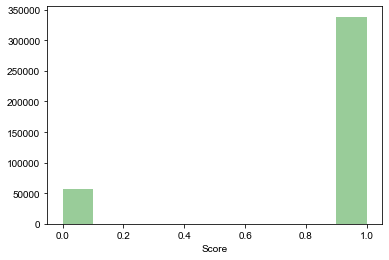

Wall time: 487 ms


In [36]:
%%time
import seaborn as sn
sn.distplot(final_data['Score'],kde = False,bins = 10, color = 'green')
plt.style.use('seaborn-darkgrid')
plt.show()
plt.rcParams['figure.figsize'] = (10,10)

**KDE plot over class label in the final_data**

Wall time: 2min 33s


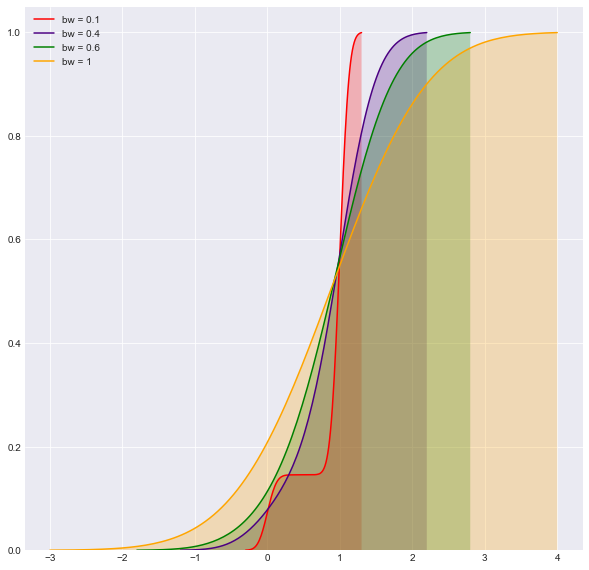

In [37]:
%%time
sn.kdeplot(final_data['Score'],cumulative  = True , color = 'red',shade = True, bw = .1,label = 'bw = 0.1')
sn.kdeplot(final_data['Score'],cumulative  = True , color = 'indigo',shade = True, bw = .4,label = 'bw = 0.4')
sn.kdeplot(final_data['Score'],cumulative  = True , color = 'green',shade = True, bw = .6,label = 'bw = 0.6')
sn.kdeplot(final_data['Score'],cumulative  = True , color = 'orange',shade = True, bw = 1, label = 'bw = 1')
plt.rcParams['figure.figsize'] = (10,10)

**Script for Removing HTML tags**

In [38]:
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string

import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  return cleanr.sub(' ',raw_html)
  
testing = cleanhtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')
print(testing)

 I Want This  text!   


**Script for Removing Punctuations**

In [39]:
# https://www.geeksforgeeks.org/removing-punctuations-given-string/
import string
string.punctuation

def remove_punc(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

**Script for Removing URLs**

In [40]:
# https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
import re 
def remove_URL(sample):
    """Remove URLs from a sample string"""
    p = re.compile('http\S+')
    return p.sub('', sample)
check = remove_URL('This data set is taken from  https://snap.stanford.edu/data/web-FineFoods.html or https://www.kaggle.com/snap/amazon-fine-food-reviews ')
print(check)

print(remove_URL('The research paper for this project is  http://i.stanford.edu/~julian/pdfs/recsys13.pdf'))

This data set is taken from   or  
The research paper for this project is  


**Script for Removing Words with Numbers**

In [41]:
def remove_words_withnumbers(sample):
    
    """Remove URLs from a sample string"""
    q = re.compile("\d")
    return q.sub(' ', sample)
working = remove_words_withnumbers('deeplearning ksjdaskj 34i290480')
print(working)

deeplearning ksjdaskj   i      


**Script for Removing Special Characters from the words**

In [42]:
def remove_specialcharacters(sample):
    """Remove Special characters from a sample string"""
    gh = re.compile("[^A-Za-z0-9]+")
    return gh.sub(' ',sample)
working = remove_specialcharacters('abd 1%2&**^$336363#886#')
print(working)

abd 1 2 336363 886 


**Script to Convert Upper case to Lower case**

In [43]:
def to_Lowercase(string):
    return string.lower()
print(to_Lowercase('SrK'))
print(to_Lowercase('kvPY'))

srk
kvpy


**Removing Multiple Spaces**

In [44]:
def remove_multiplespace(text):
    jk = re.compile(r"\s+")
    return jk.sub(' ',text)
klm = remove_multiplespace('The film      Pulp Fiction      was released in   year 1994.')
print(klm)

The film Pulp Fiction was released in year 1994.


**Removing Stop Words**

In [45]:
pip install --user -U nltk

Requirement already up-to-date: nltk in c:\users\user\appdata\roaming\python\python37\site-packages (3.5)
Note: you may need to restart the kernel to use updated packages.


In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

# make a list of all common negative words and make sure they are not removed, since they
# are an important aspect to determine neagtive sentiment of the reviews
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',"didn't",
'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
"isn't",
'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
"wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

new_stops = [words for words in stop if words not in excluding]
print(new_stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [104]:
texts_original = pd.DataFrame(final_data['Text'])
texts_original

Text
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [105]:
print(f'Input data has {len(texts_original)} rows, {len(texts_original.columns)} columns')

Input data has 396293 rows, 1 columns


In [106]:
pd.set_option('display.max_colwidth',4000)
texts_original

Text
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [107]:
texts_original = texts_original.rename(columns = {'Text':'Original_Review_Text'})
texts_original

Original_Review_Text
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [109]:
%%time
texts_original['Htmltags_removed'] = texts_original['Original_Review_Text'].apply(lambda x: cleanhtml(x))
texts_original['URLs_removed'] = texts_original['Htmltags_removed'].apply(lambda x: remove_URL(x))
texts_original['Removed_Words_with_numbers'] = texts_original['URLs_removed'].apply(lambda x: remove_words_withnumbers(x))
texts_original['Removed_Words_with_Special_Characters'] = texts_original['Removed_Words_with_numbers'].apply(lambda x: remove_specialcharacters(x))
texts_original['Removed_Punctuations'] = texts_original['Removed_Words_with_Special_Characters'].apply(lambda x: remove_punc(x))
texts_original['Converted_to_Lowercase'] = texts_original['Removed_Punctuations'].apply(lambda x: to_Lowercase(x))
texts_original

Wall time: 32.3 s


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Tokenization**

In [110]:
%%time
import re

def tokenize(txt):
    tokens = re.split('\W+',txt)
    return tokens

texts_original['Tokenization_applied'] = texts_original['Converted_to_Lowercase'].apply(lambda x: tokenize(x.lower()))

texts_original


Wall time: 10.6 s


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Remove Stopwords**

In [111]:
%%time
def remove_stopwords(tokenized_texts):
    txt_clean = [word for word in tokenized_texts if word not in new_stops]
    return txt_clean

texts_original['Stopwords_removed'] = texts_original['Tokenization_applied'].apply(lambda x: remove_stopwords(x))
  
texts_original

Wall time: 38.4 s


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Porter Stemming**

In [112]:
import nltk
from nltk.stem import PorterStemmer 
ps = PorterStemmer()
dir(ps)

['MARTIN_EXTENSIONS',
 'NLTK_EXTENSIONS',
 'ORIGINAL_ALGORITHM',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply_rule_list',
 '_contains_vowel',
 '_ends_cvc',
 '_ends_double_consonant',
 '_has_positive_measure',
 '_is_consonant',
 '_measure',
 '_replace_suffix',
 '_step1a',
 '_step1b',
 '_step1c',
 '_step2',
 '_step3',
 '_step4',
 '_step5a',
 '_step5b',
 'mode',
 'pool',
 'stem',
 'vowels']

In [113]:
def porter_stem (txt):
    text = [ps.stem(word) for word in txt]
    return text

In [114]:
%%time
texts_original['Porter_stemmed'] = texts_original['Stopwords_removed'].apply(lambda x : porter_stem(x))

texts_original

Wall time: 5min 24s


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Snowball Stemming**

In [115]:
from nltk.stem import SnowballStemmer
ss = SnowballStemmer('english')
dir(ss)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'languages',
 'stem',
 'stemmer',
 'stopwords']

In [116]:
def snowball_stem(txt):
    result = [ss.stem(word) for word in txt]
    return result

In [117]:
%%time 

texts_original['Snowball_stemmed'] = texts_original['Stopwords_removed'].apply(lambda x : snowball_stem(x))

texts_original

Wall time: 3min 36s


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [118]:
#with open('mytable.tex','w') as tf:
#    tf.write(texts_original.head().to_latex())

**Word Net Lemmatization**

In [119]:
import nltk 
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
dir(wn)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'lemmatize']

In [120]:
%%time
print(ss.stem('goose'))
print(ss.stem('geese'))

goos
gees
Wall time: 0 ns


In [121]:
%%time
print(wn.lemmatize('goose'))
print(wn.lemmatize('geese'))

goose
goose
Wall time: 997 µs


From the above we can see that Lemmatization is slower than stemming , but it's much more accurate than steeming

**Lemmatization**

In [122]:
def lemmatize(text):
    fgh = [wn.lemmatize(word) for word in text]
    return fgh

In [123]:
%%time

texts_original['Wordnet_Lemmatized'] = texts_original['Stopwords_removed'].apply(lambda x : lemmatize(x))

texts_original

Wall time: 1min


Original_Review_Text  \
150528                                                                                                                          In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.   
150506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           This is a fun way for children to learn their months of the year!  We will learn all of the poems throughout the school year.  they like the handmotions which I invent for each poem.   
150505                                                                                                                                                                                                                                                                                                                                                                                                                                             I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.   
150504                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.   
150503                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     A very entertaining rhyming story--cleaver and catchy.The illustrations are imaginative and fit right in. However, the paperback is somewhat small and flimsy. I'd opt for a bigger edition.   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

**Unigram only Bag Of Words**

In [124]:
final_data.shape

(396293, 10)

In [125]:
texts_original.shape

(396293, 12)

In [126]:
new_df = texts_original[['Converted_to_Lowercase','Tokenization_applied','Stopwords_removed','Wordnet_Lemmatized']]
new_df

Converted_to_Lowercase  \
150528                                                      in june i saw a charming group of roses all begin to droop i pepped them up with chicken soup sprinkle once sprinkle twice sprinkle chicken soup with rice this is a great book to teach children the months of the year the repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read this isn t nearly as good as some of sendak s other books like where the wild things are or pierre the boy who didn t care but it still carries his unique brand of charm    
150506                                                                                                                                                                                                                                                                                                                                                                                            this is a fun way for children to learn their months of the year we will learn all of the poems throughout the school year they like the handmotions which i invent for each poem    
150505                                                                                                                                                                                                                                                                                                                i grew up reading these sendak books and watching the really rosie movie that incorporates them and love them my son loves them too i do however miss the hard cover version the paperbacks seem kind of flimsy and it takes two hands to keep the pages open    
150504                                                                                                                                                                                                                                                                                                                                                                                                      get the movie or sound track and sing along with carol king this is great stuff my whole extended family knows these songs by heart quality kids storytelling and music    
150503                                                                                                                                                                                                                                                                                                                                                                                      a very entertaining rhyming story cleaver and catchy the illustrations are imaginative and fit right in however the paperback is somewhat small and flimsy i d opt for a bigger edition    
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ...   
193171                                                                                                                                                                                                                                                                                                                                                                                                                    fts zero is the best sweetener i have ever tried no aftertaste no stomach issues and the bottle lasts forever as you get a potent dose with just one drop   

In [127]:
def join(txt):
    txt_joined = " ".join([c for c in txt])
    return txt_joined

In [128]:
%%time
new_df['Final_Preprocessed_words'] = new_df['Wordnet_Lemmatized'].apply(lambda x : join(x))
new_df

Wall time: 1.07 s


Converted_to_Lowercase  \
150528                                                      in june i saw a charming group of roses all begin to droop i pepped them up with chicken soup sprinkle once sprinkle twice sprinkle chicken soup with rice this is a great book to teach children the months of the year the repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read this isn t nearly as good as some of sendak s other books like where the wild things are or pierre the boy who didn t care but it still carries his unique brand of charm    
150506                                                                                                                                                                                                                                                                                                                                                                                            this is a fun way for children to learn their months of the year we will learn all of the poems throughout the school year they like the handmotions which i invent for each poem    
150505                                                                                                                                                                                                                                                                                                                i grew up reading these sendak books and watching the really rosie movie that incorporates them and love them my son loves them too i do however miss the hard cover version the paperbacks seem kind of flimsy and it takes two hands to keep the pages open    
150504                                                                                                                                                                                                                                                                                                                                                                                                      get the movie or sound track and sing along with carol king this is great stuff my whole extended family knows these songs by heart quality kids storytelling and music    
150503                                                                                                                                                                                                                                                                                                                                                                                      a very entertaining rhyming story cleaver and catchy the illustrations are imaginative and fit right in however the paperback is somewhat small and flimsy i d opt for a bigger edition    
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ...   
193171                                                                                                                                                                                                                                                                                                                                                                                                                    fts zero is the best sweetener i have ever tried no aftertaste no stomach issues and the bottle lasts forever as you get a potent dose with just one drop   

**Count Vectorization - Unigram BOW on Limited no. of Reviews**

In [129]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

corpus = new_df['Final_Preprocessed_words'].values[0:10]

x = cv.fit(corpus)
print(x.vocabulary_)
print(cv.get_feature_names())

y = cv.transform(corpus)
print(y.shape)
print(y.toarray())

{'june': 75, 'saw': 132, 'charming': 25, 'group': 58, 'rose': 130, 'begin': 11, 'droop': 38, 'pepped': 109, 'chicken': 26, 'soup': 153, 'sprinkle': 154, 'twice': 172, 'rice': 128, 'great': 56, 'book': 14, 'teach': 162, 'child': 27, 'month': 95, 'year': 189, 'repetition': 124, 'phrase': 111, 'funny': 52, 'little': 86, 'story': 156, 'accompanying': 2, 'picture': 112, 'make': 90, 'ideal': 66, 'bedtime': 10, 'read': 119, 'isn': 74, 'nearly': 100, 'good': 54, 'sendak': 136, 'like': 84, 'wild': 185, 'thing': 165, 'pierre': 113, 'boy': 16, 'didn': 35, 'care': 18, 'still': 155, 'carry': 20, 'unique': 177, 'brand': 17, 'charm': 24, 'fun': 51, 'way': 183, 'learn': 82, 'poem': 114, 'throughout': 167, 'school': 133, 'handmotions': 60, 'invent': 73, 'grew': 57, 'reading': 120, 'watching': 182, 'really': 121, 'rosie': 131, 'movie': 97, 'incorporates': 70, 'love': 87, 'son': 150, 'however': 64, 'miss': 94, 'hard': 61, 'cover': 31, 'version': 179, 'paperback': 106, 'seem': 135, 'kind': 78, 'flimsy': 4

In [130]:
print(y)

subdf = pd.DataFrame(y.toarray(), columns = cv.get_feature_names())
subdf

  (0, 2)	1
  (0, 10)	1
  (0, 11)	1
  (0, 14)	2
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 20)	1
  (0, 24)	1
  (0, 25)	1
  (0, 26)	2
  (0, 27)	1
  (0, 35)	1
  (0, 38)	1
  (0, 52)	1
  (0, 54)	1
  (0, 56)	1
  (0, 58)	1
  (0, 66)	1
  (0, 74)	1
  (0, 75)	1
  (0, 84)	1
  (0, 86)	1
  (0, 90)	1
  (0, 95)	1
  :	:
  (9, 5)	1
  (9, 14)	1
  (9, 26)	1
  (9, 32)	1
  (9, 37)	1
  (9, 40)	1
  (9, 46)	1
  (9, 51)	1
  (9, 63)	1
  (9, 86)	1
  (9, 87)	1
  (9, 88)	1
  (9, 95)	1
  (9, 101)	1
  (9, 102)	1
  (9, 108)	1
  (9, 128)	1
  (9, 144)	1
  (9, 153)	1
  (9, 168)	1
  (9, 173)	1
  (9, 176)	1
  (9, 181)	1
  (9, 187)	1
  (9, 189)	1


able  absolutely  accompanying  actually  add  ago  aired  along  \
0     0           0             1         0    0    0      0      0   
1     0           0             0         0    0    0      0      0   
2     0           0             0         0    0    0      0      0   
3     0           0             0         0    0    0      0      1   
4     0           0             0         0    0    0      0      0   
5     0           0             0         1    0    0      0      0   
6     0           1             0         0    0    0      0      0   
7     0           0             0         0    0    1      1      1   
8     1           0             0         0    0    0      0      0   
9     0           0             0         0    1    1      0      0   

   attention  beautifully  ...  wanted  warned  watching  way  whole  wild  \
0          0            0  ...       0       0         0    0      0     1   
1          0            0  ...       0       0         0    1      0     0   
2          0            0  ...       0       0         1    0      0     0   
3          0            0  ...       0       0         0    0      1     0   
4          0            0  ...       0       0         0    0      0     0   
5          0            0  ...       0       0         0    0      0     0   
6          1            1  ...       1       0         0    2      0     0   
7          0            0  ...       0       0         0    0      1     0   
8          0            0  ...       0       0         0    0      0     0   
9          0            0  ...       0       1         0    0      0     0   

   wonder  wonderful  writing  year  
0       0          0        0     1  
1       0          0        0     2  
2       0          0        0     0  
3       0          0        0     0  
4       0          0        0     0  
5       0          0        0     0  
6       1          0        0     1  
7       0          0        0     1  
8       0          0        1     0  
9       0          1        0     1  

[10 rows x 190 columns]

**Count Vectorizer on All Review Texts - Unigrams**

In [131]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer()

corpus1 = new_df['Final_Preprocessed_words']
x = cv1.fit(corpus1)

Wall time: 14.3 s


In [132]:
# print(x.vocabulary_) - for getting the frequency count of each word of Uni gram Model

In [133]:
# print(cv1.get_feature_names()) - for getting name of each unique feature in Unigrams Model

In [134]:
fc = cv1.fit_transform(corpus1)

In [135]:
print(fc.shape)

(396293, 98142)


There are 98k unique set of words like it can be observed above 

**Bi-gram and N-gram Count Vectorization - BOW**

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
cv2 = CountVectorizer(ngram_range = (2,2))

dox = new_df['Final_Preprocessed_words'].values[0:10]

    
z = cv2.fit(corpus)
print(z.vocabulary_)
print(cv2.get_feature_names())

xy = cv2.transform(corpus)
print(xy.shape)
print(xy.toarray())


{'june saw': 100, 'saw charming': 177, 'charming group': 37, 'group rose': 82, 'rose begin': 175, 'begin droop': 13, 'droop pepped': 57, 'pepped chicken': 147, 'chicken soup': 38, 'soup sprinkle': 203, 'sprinkle sprinkle': 205, 'sprinkle twice': 206, 'twice sprinkle': 227, 'sprinkle chicken': 204, 'soup rice': 202, 'rice great': 173, 'great book': 79, 'book teach': 26, 'teach child': 217, 'child month': 40, 'month year': 130, 'year repetition': 251, 'repetition phrase': 167, 'phrase funny': 149, 'funny little': 75, 'little story': 114, 'story accompanying': 208, 'accompanying picture': 2, 'picture make': 150, 'make ideal': 122, 'ideal bedtime': 91, 'bedtime read': 12, 'read isn': 157, 'isn nearly': 99, 'nearly good': 135, 'good sendak': 77, 'sendak book': 182, 'book like': 19, 'like wild': 110, 'wild thing': 243, 'thing pierre': 221, 'pierre boy': 151, 'boy didn': 29, 'didn care': 53, 'care still': 31, 'still carry': 207, 'carry unique': 33, 'unique brand': 232, 'brand charm': 30, 'fun

In [137]:
print(xy)

subdf1 = pd.DataFrame(xy.toarray(), columns = cv2.get_feature_names())
subdf1

  (0, 2)	1
  (0, 12)	1
  (0, 13)	1
  (0, 19)	1
  (0, 26)	1
  (0, 29)	1
  (0, 30)	1
  (0, 31)	1
  (0, 33)	1
  (0, 37)	1
  (0, 38)	2
  (0, 40)	1
  (0, 53)	1
  (0, 57)	1
  (0, 75)	1
  (0, 77)	1
  (0, 79)	1
  (0, 82)	1
  (0, 91)	1
  (0, 99)	1
  (0, 100)	1
  (0, 110)	1
  (0, 114)	1
  (0, 122)	1
  (0, 130)	1
  :	:
  (9, 4)	1
  (9, 6)	1
  (9, 20)	1
  (9, 38)	1
  (9, 48)	1
  (9, 56)	1
  (9, 58)	1
  (9, 66)	1
  (9, 73)	1
  (9, 87)	1
  (9, 112)	1
  (9, 115)	1
  (9, 120)	1
  (9, 129)	1
  (9, 137)	1
  (9, 140)	1
  (9, 146)	1
  (9, 172)	1
  (9, 191)	1
  (9, 202)	1
  (9, 228)	1
  (9, 231)	1
  (9, 236)	1
  (9, 245)	1
  (9, 247)	1


able read  absolutely silly  accompanying picture  actually enjoy  add fun  \
0          0                 0                     1               0        0   
1          0                 0                     0               0        0   
2          0                 0                     0               0        0   
3          0                 0                     0               0        0   
4          0                 0                     0               0        0   
5          0                 0                     0               1        0   
6          0                 1                     0               0        0   
7          0                 0                     0               0        0   
8          1                 0                     0               0        0   
9          0                 0                     0               0        1   

   ago child  ago twin  aired television  along book  along carol  ...  \
0          0         0                 0           0            0  ...   
1          0         0                 0           0            0  ...   
2          0         0                 0           0            0  ...   
3          0         0                 0           0            1  ...   
4          0         0                 0           0            0  ...   
5          0         0                 0           0            0  ...   
6          0         0                 0           0            0  ...   
7          1         0                 1           1            0  ...   
8          0         0                 0           0            0  ...   
9          0         1                 0           0            0  ...   

   whole school  wild thing  wonder little  wonderful little  writing type  \
0             0           1              0                 0             0   
1             0           0              0                 0             0   
2             0           0              0                 0             0   
3             0           0              0                 0             0   
4             0           0              0                 0             0   
5             0           0              0                 0             0   
6             0           0              1                 0             0   
7             1           0              0                 0             0   
8             0           0              0                 0             1   
9             0           0              0                 1             0   

   year ago  year learn  year like  year not  year repetition  
0         0           0          0         0                1  
1         0           1          1         0                0  
2         0           0          0         0                0  
3         0           0          0         0                0  
4         0           0          0         0                0  
5         0           0          0         0                0  
6         0           0          0         1                0  
7         1           0          0         0                0  
8         0           0          0         0                0  
9         1           0          0         0                0  

[10 rows x 252 columns]

**Count Vectorizer on All Review Texts - Bigrams Only**

In [138]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
cv3 = CountVectorizer(ngram_range = (2,2))

corpus2 = new_df['Final_Preprocessed_words']
ty = cv3.fit_transform(corpus2)

Wall time: 38.5 s


In [139]:
print(ty.shape)

(396293, 3732580)


In [140]:
print(cv3.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Generating Word Clouds on entire Data**

In [141]:
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [142]:
%%time 

text = " ".join(txt for txt in new_df.Final_Preprocessed_words)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create and generate a word cloud image:
wc = WordCloud(background_color="white",width=1600, height=800).generate(text)

There are 103896438 words in the combination of all review.
Wall time: 1min 19s


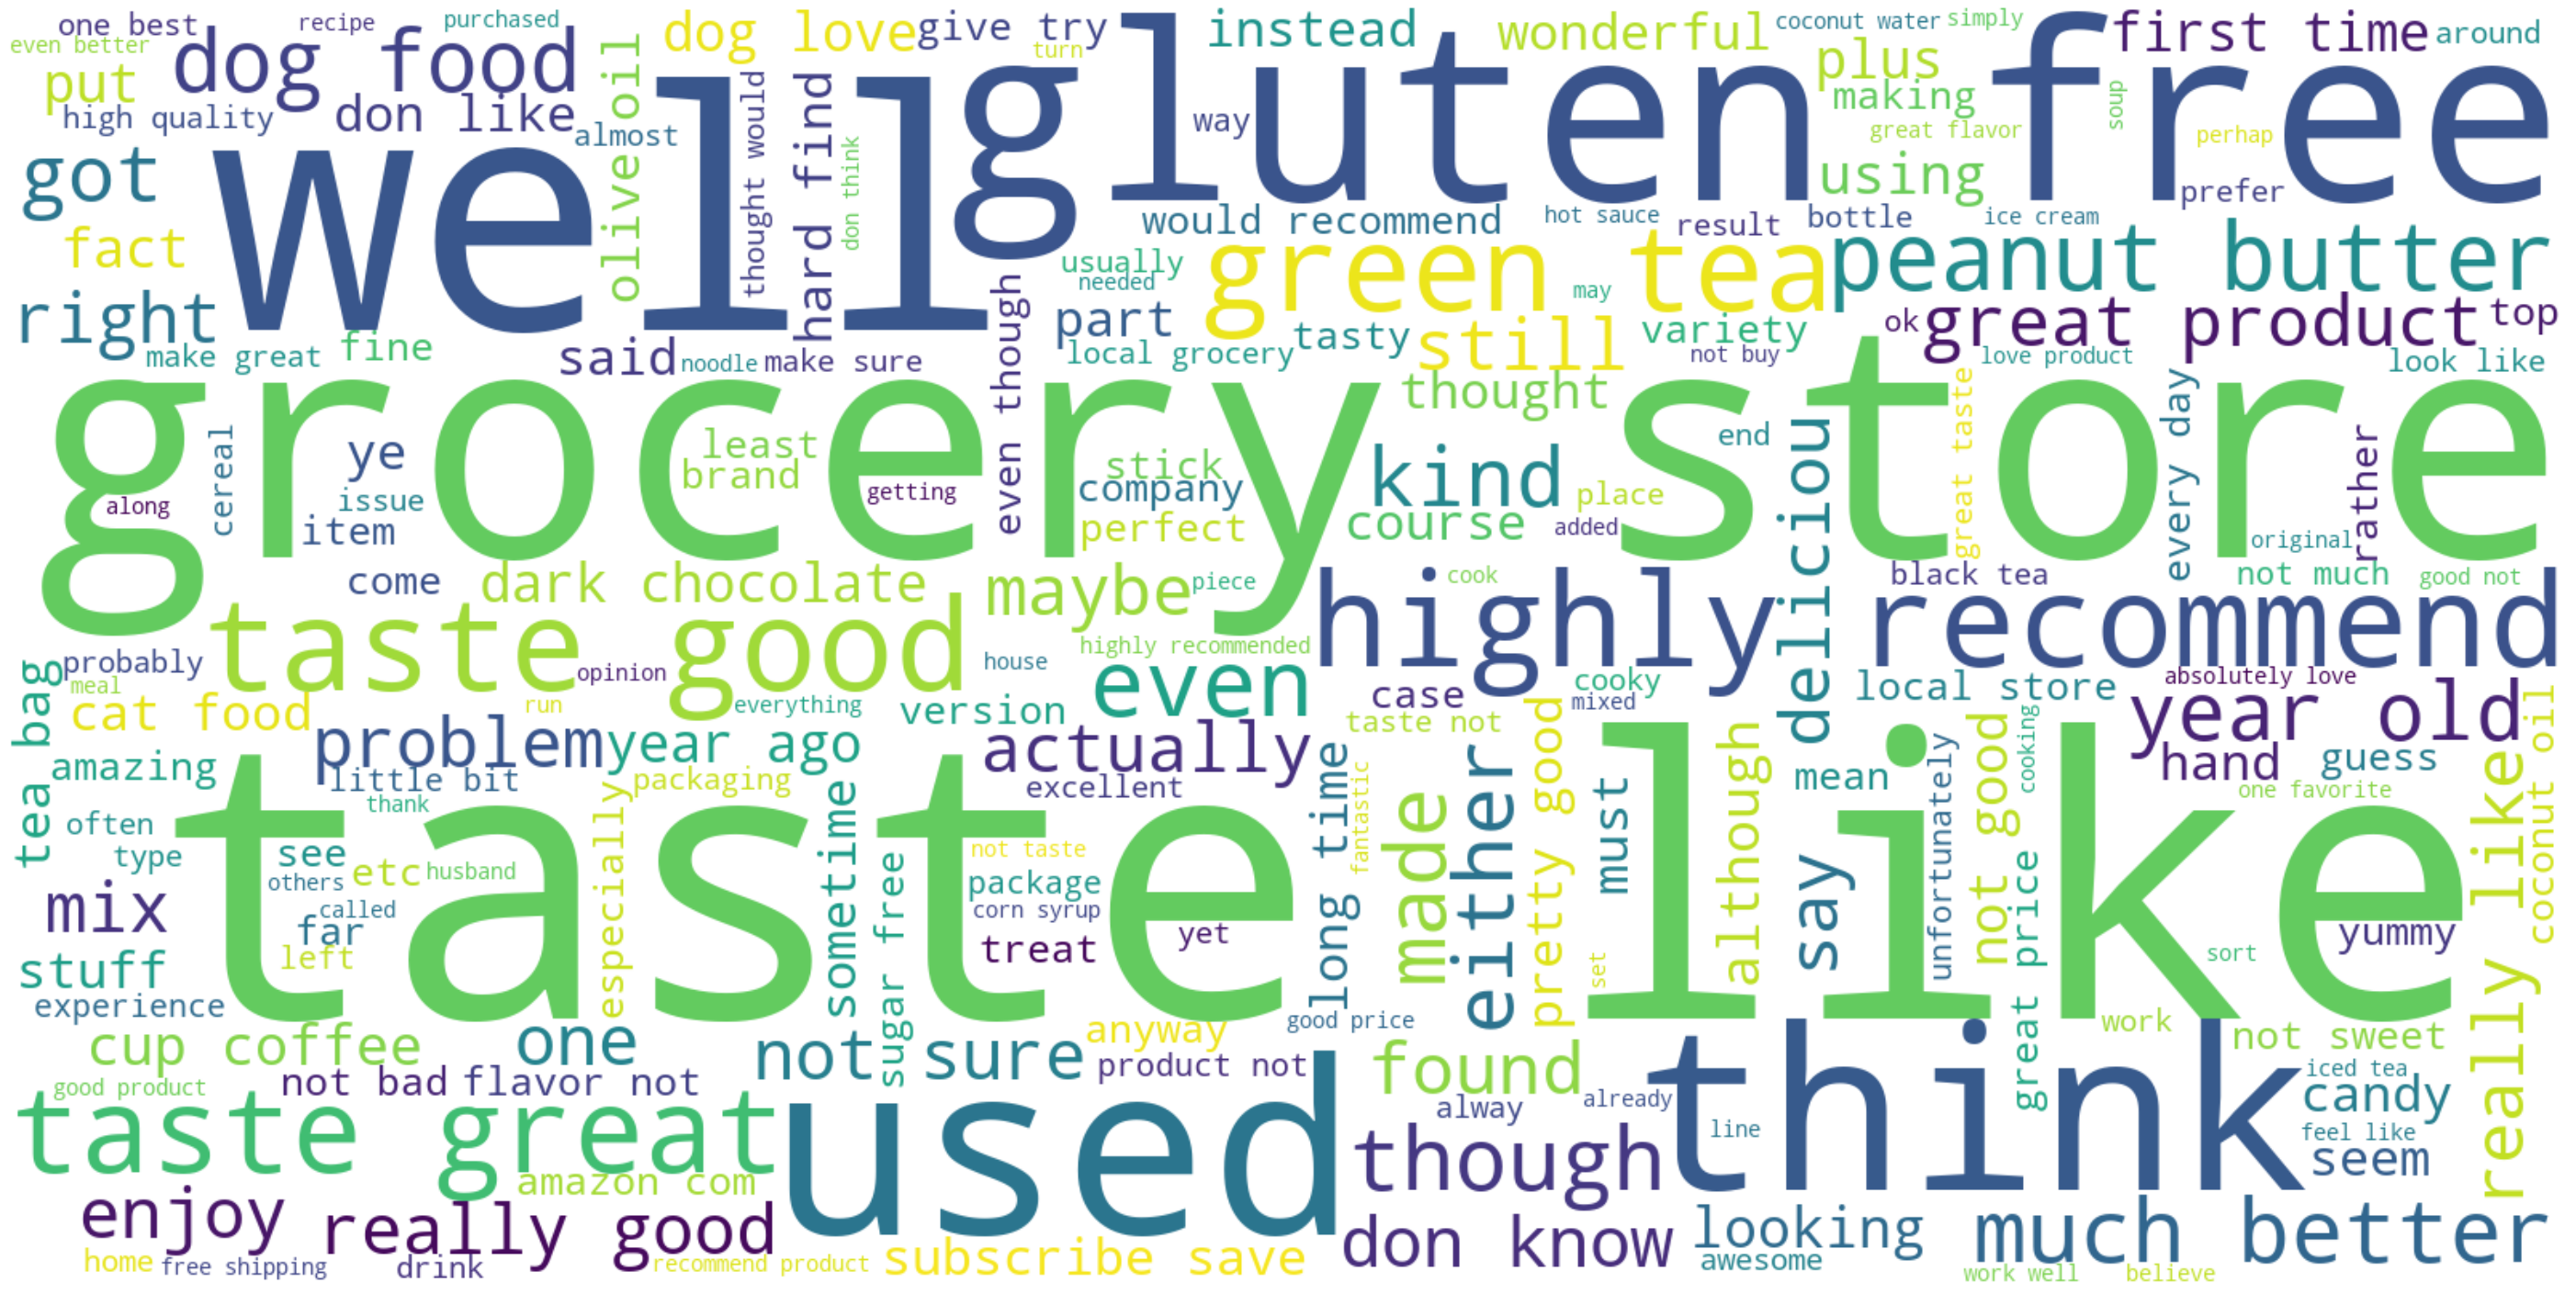

<Figure size 3600x2880 with 0 Axes>

In [143]:
# https://www.datacamp.com/community/tutorials/wordcloud-python

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.rcParams['figure.figsize'] = (50,40)
plt.tight_layout(pad=0)

**Tri - Grams**

In [144]:
from sklearn.feature_extraction.text import CountVectorizer
cv_3 = CountVectorizer(ngram_range = (3,3))

files = new_df['Final_Preprocessed_words'].values[0:10]


ui = cv_3.fit(corpus)
print(ui.vocabulary_)
print(cv_3.get_feature_names())

xyz = cv_3.transform(corpus)
print(xyz.shape)
print(xyz.toarray())

{'june saw charming': 97, 'saw charming group': 175, 'charming group rose': 35, 'group rose begin': 80, 'rose begin droop': 173, 'begin droop pepped': 13, 'droop pepped chicken': 56, 'pepped chicken soup': 145, 'chicken soup sprinkle': 37, 'soup sprinkle sprinkle': 202, 'sprinkle sprinkle twice': 204, 'sprinkle twice sprinkle': 205, 'twice sprinkle chicken': 224, 'sprinkle chicken soup': 203, 'chicken soup rice': 36, 'soup rice great': 201, 'rice great book': 171, 'great book teach': 77, 'book teach child': 25, 'teach child month': 215, 'child month year': 39, 'month year repetition': 130, 'year repetition phrase': 248, 'repetition phrase funny': 165, 'phrase funny little': 147, 'funny little story': 73, 'little story accompanying': 112, 'story accompanying picture': 207, 'accompanying picture make': 2, 'picture make ideal': 148, 'make ideal bedtime': 120, 'ideal bedtime read': 89, 'bedtime read isn': 12, 'read isn nearly': 155, 'isn nearly good': 96, 'nearly good sendak': 135, 'good s

In [145]:
print(xyz)

subdf2 = pd.DataFrame(xyz.toarray(), columns = cv_3.get_feature_names())
subdf2

  (0, 2)	1
  (0, 12)	1
  (0, 13)	1
  (0, 18)	1
  (0, 25)	1
  (0, 28)	1
  (0, 29)	1
  (0, 31)	1
  (0, 35)	1
  (0, 36)	1
  (0, 37)	1
  (0, 39)	1
  (0, 52)	1
  (0, 56)	1
  (0, 73)	1
  (0, 75)	1
  (0, 77)	1
  (0, 80)	1
  (0, 89)	1
  (0, 96)	1
  (0, 97)	1
  (0, 107)	1
  (0, 112)	1
  (0, 120)	1
  (0, 130)	1
  :	:
  (8, 242)	1
  (9, 4)	1
  (9, 6)	1
  (9, 19)	1
  (9, 36)	1
  (9, 47)	1
  (9, 55)	1
  (9, 57)	1
  (9, 64)	1
  (9, 71)	1
  (9, 85)	1
  (9, 109)	1
  (9, 113)	1
  (9, 118)	1
  (9, 127)	1
  (9, 139)	1
  (9, 144)	1
  (9, 170)	1
  (9, 189)	1
  (9, 200)	1
  (9, 225)	1
  (9, 228)	1
  (9, 233)	1
  (9, 241)	1
  (9, 244)	1


able read one  absolutely silly much  accompanying picture make  \
0              0                      0                          1   
1              0                      0                          0   
2              0                      0                          0   
3              0                      0                          0   
4              0                      0                          0   
5              0                      0                          0   
6              0                      1                          0   
7              0                      0                          0   
8              1                      0                          0   
9              0                      0                          0   

   actually enjoy reading  add fun warned  ago child sister  ago twin love  \
0                       0               0                 0              0   
1                       0               0                 0              0   
2                       0               0                 0              0   
3                       0               0                 0              0   
4                       0               0                 0              0   
5                       1               0                 0              0   
6                       0               0                 0              0   
7                       0               0                 1              0   
8                       0               0                 0              0   
9                       0               1                 0              1   

   aired television year  along book child  along carol king  ...  \
0                      0                 0                 0  ...   
1                      0                 0                 0  ...   
2                      0                 0                 0  ...   
3                      0                 0                 1  ...   
4                      0                 0                 0  ...   
5                      0                 0                 0  ...   
6                      0                 0                 0  ...   
7                      1                 1                 0  ...   
8                      0                 0                 0  ...   
9                      0                 0                 0  ...   

   wild thing pierre  wonder little book  wonderful little book  \
0                  1                   0                      0   
1                  0                   0                      0   
2                  0                   0                      0   
3                  0                   0                      0   
4                  0                   0                      0   
5                  0                   0                      0   
6                  0                   1                      0   
7                  0                   0                      0   
8                  0                   0                      0   
9                  0                   0                      1   

   writing type book  year ago child  year ago twin  year learn poem  \
0                  0               0              0                0   
1                  0               0              0                1   
2                  0               0              0                0   
3                  0               0              0                0   
4                  0               0              0                0   
5                  0               0              0                0   
6                  0               0              0                0   
7                  0               1              0                0   
8                  1               0              0                0   
9                  0               0              1                0   

   year like handmotions  year not mention  year repetition phrase  
0            

In [146]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
cv4 = CountVectorizer(ngram_range = (3,3))

corpus_3 = new_df['Final_Preprocessed_words']
tyq = cv_3.fit_transform(corpus_3)

Wall time: 1min 19s


In [147]:
print(tyq.shape)

(396293, 11366120)


In [148]:
our_df = new_df[['Wordnet_Lemmatized','Final_Preprocessed_words']]
our_df

Wordnet_Lemmatized  \
150528                                    [june, saw, charming, group, rose, begin, droop, pepped, chicken, soup, sprinkle, sprinkle, twice, sprinkle, chicken, soup, rice, great, book, teach, child, month, year, repetition, phrase, funny, little, story, accompanying, picture, make, ideal, bedtime, read, isn, nearly, good, sendak, book, like, wild, thing, pierre, boy, didn, care, still, carry, unique, brand, charm, ]   
150506                                                                                                                                                                                                                                                                                                              [fun, way, child, learn, month, year, learn, poem, throughout, school, year, like, handmotions, invent, poem, ]   
150505                                                                                                                                                                                                                        [grew, reading, sendak, book, watching, really, rosie, movie, incorporates, love, son, love, however, miss, hard, cover, version, paperback, seem, kind, flimsy, take, two, hand, keep, page, open, ]   
150504                                                                                                                                                                                                                                                                          [get, movie, sound, track, sing, along, carol, king, great, stuff, whole, extended, family, know, song, heart, quality, kid, storytelling, music, ]   
150503                                                                                                                                                                                                                                                                  [entertaining, rhyming, story, cleaver, catchy, illustration, imaginative, fit, right, however, paperback, somewhat, small, flimsy, opt, bigger, edition, ]   
...                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
193171                                                                                                                                                                                                                                                                                                  [ft, zero, best, sweetener, ever, tried, aftertaste, stomach, issue, bottle, last, forever, get, potent, dose, one, drop, ]   
188388  [try, sauce, believe, start, little, sweet, honey, taste, bud, become, alive, flavor, sweet, onion, garlic, whiskey, mesquite, smoked, flavor, analyzing, flavor, second, get, awesome, habanero, kick, come, back, side, mouth, slowly, rise, heat, stage, hotter, sweet, whiskey, habanero, sauce, way, overwhelming, leaf, bad, taste, mouth, simply, perfect, cant, wait, try, smoked, tennessee, maple, sauce, next, ]   
221794                                                                                                                                                                                                                                                                                                        [bought, hazelnut, paste, nocciola, spread, local, shop, palm, cost, florida, taste, excellent, healthier, nutella, ]   
5702                                                                                                                                                                       

In [149]:
wer = pd.DataFrame(final_data['Score'])
wer

Score
150528      1
150506      1
150505      1
150504      1
150503      1
...       ...
193171      1
188388      1
221794      1
5702        1
327600      1

[396293 rows x 1 columns]

In [150]:
our_df['Score'] = wer['Score']

In [151]:
our_df

Wordnet_Lemmatized  \
150528                                    [june, saw, charming, group, rose, begin, droop, pepped, chicken, soup, sprinkle, sprinkle, twice, sprinkle, chicken, soup, rice, great, book, teach, child, month, year, repetition, phrase, funny, little, story, accompanying, picture, make, ideal, bedtime, read, isn, nearly, good, sendak, book, like, wild, thing, pierre, boy, didn, care, still, carry, unique, brand, charm, ]   
150506                                                                                                                                                                                                                                                                                                              [fun, way, child, learn, month, year, learn, poem, throughout, school, year, like, handmotions, invent, poem, ]   
150505                                                                                                                                                                                                                        [grew, reading, sendak, book, watching, really, rosie, movie, incorporates, love, son, love, however, miss, hard, cover, version, paperback, seem, kind, flimsy, take, two, hand, keep, page, open, ]   
150504                                                                                                                                                                                                                                                                          [get, movie, sound, track, sing, along, carol, king, great, stuff, whole, extended, family, know, song, heart, quality, kid, storytelling, music, ]   
150503                                                                                                                                                                                                                                                                  [entertaining, rhyming, story, cleaver, catchy, illustration, imaginative, fit, right, however, paperback, somewhat, small, flimsy, opt, bigger, edition, ]   
...                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
193171                                                                                                                                                                                                                                                                                                  [ft, zero, best, sweetener, ever, tried, aftertaste, stomach, issue, bottle, last, forever, get, potent, dose, one, drop, ]   
188388  [try, sauce, believe, start, little, sweet, honey, taste, bud, become, alive, flavor, sweet, onion, garlic, whiskey, mesquite, smoked, flavor, analyzing, flavor, second, get, awesome, habanero, kick, come, back, side, mouth, slowly, rise, heat, stage, hotter, sweet, whiskey, habanero, sauce, way, overwhelming, leaf, bad, taste, mouth, simply, perfect, cant, wait, try, smoked, tennessee, maple, sauce, next, ]   
221794                                                                                                                                                                                                                                                                                                        [bought, hazelnut, paste, nocciola, spread, local, shop, palm, cost, florida, taste, excellent, healthier, nutella, ]   
5702                                                                                                                                                                       

In [155]:
neg = our_df[our_df['Score'] == 0]
neg

Wordnet_Lemmatized  \
150496                                                                                                                                                   [give, five, star, maurice, sendak, story, one, star, printed, edition, book, child, older, copy, book, familiar, previous, softcover, version, ordered, granddaughter, embarrassed, give, gift, look, puny, book, size, postcard, think, overpriced, learned, lesson, not, buying, softcover, child, book, next, time, get, used, copy, ]   
150525                                                                                                                                                                                                                                                                                                                            [one, best, child, book, ever, written, mini, version, book, not, portrayed, one, priced, product, sent, email, regarding, bewilderment, amazon, got, response, ]   
24749                                                                                                                                                                                                                                                                                                   [dog, love, chicken, product, china, wont, buying, anymore, hard, find, chicken, product, made, usa, one, isnt, bad, good, product, wont, take, chance, till, know, going, china, import, ]   
171185                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [price, dr, foster, smith, ]   
171181                                                                                                                                                                                                                      [okay, freeze, dried, liver, cube, let, common, sense, tell, lot, le, price, treat, could, buy, real, liver, cube, freeze, would, serve, purpose, lot, le, money, would, not, processed, said, dog, would, back, flip, treat, made, money, go, ahead, make, dog, day, ]   
...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
68917                                                                                                                                                                                                                                                                                                                                                                                   [unimpressed, almond, clovey, musty, taste, expecting, sweet, treat, won, get, almond, save, money, make, ]   
352209  [spice, tasted, harsh, raw, weird, taste, maybe, much, asafoetida, comparison, simple, homemade, rasam, tried, improve, flavor, adding, cilantro, still, rasam, still, not, taste, good, next, added, packet, mtr, ready, eat, sambar, small, eggplant, minced, carrot, diced, potato, string, bean, okra, cilantro, rasam, sambar, passable, would, lot, better, made, scratch, took, lot, time, defeated, point, using, ready, eat, packet, like, mtr, spice, mixture, not, ready, eat, ]   
271311                                                                            

**Word Cloud on Negative words**

In [159]:
%%time 

fly = " ".join(txt for txt in neg.Final_Preprocessed_words)
print ("There are {} words in the combination of negative review.".format(len(fly)))

# Create and generate a word cloud image:
cloud = WordCloud(background_color="white",width=1600, height=800).generate(fly)

There are 16362278 words in the combination of negative review.
Wall time: 15.7 s


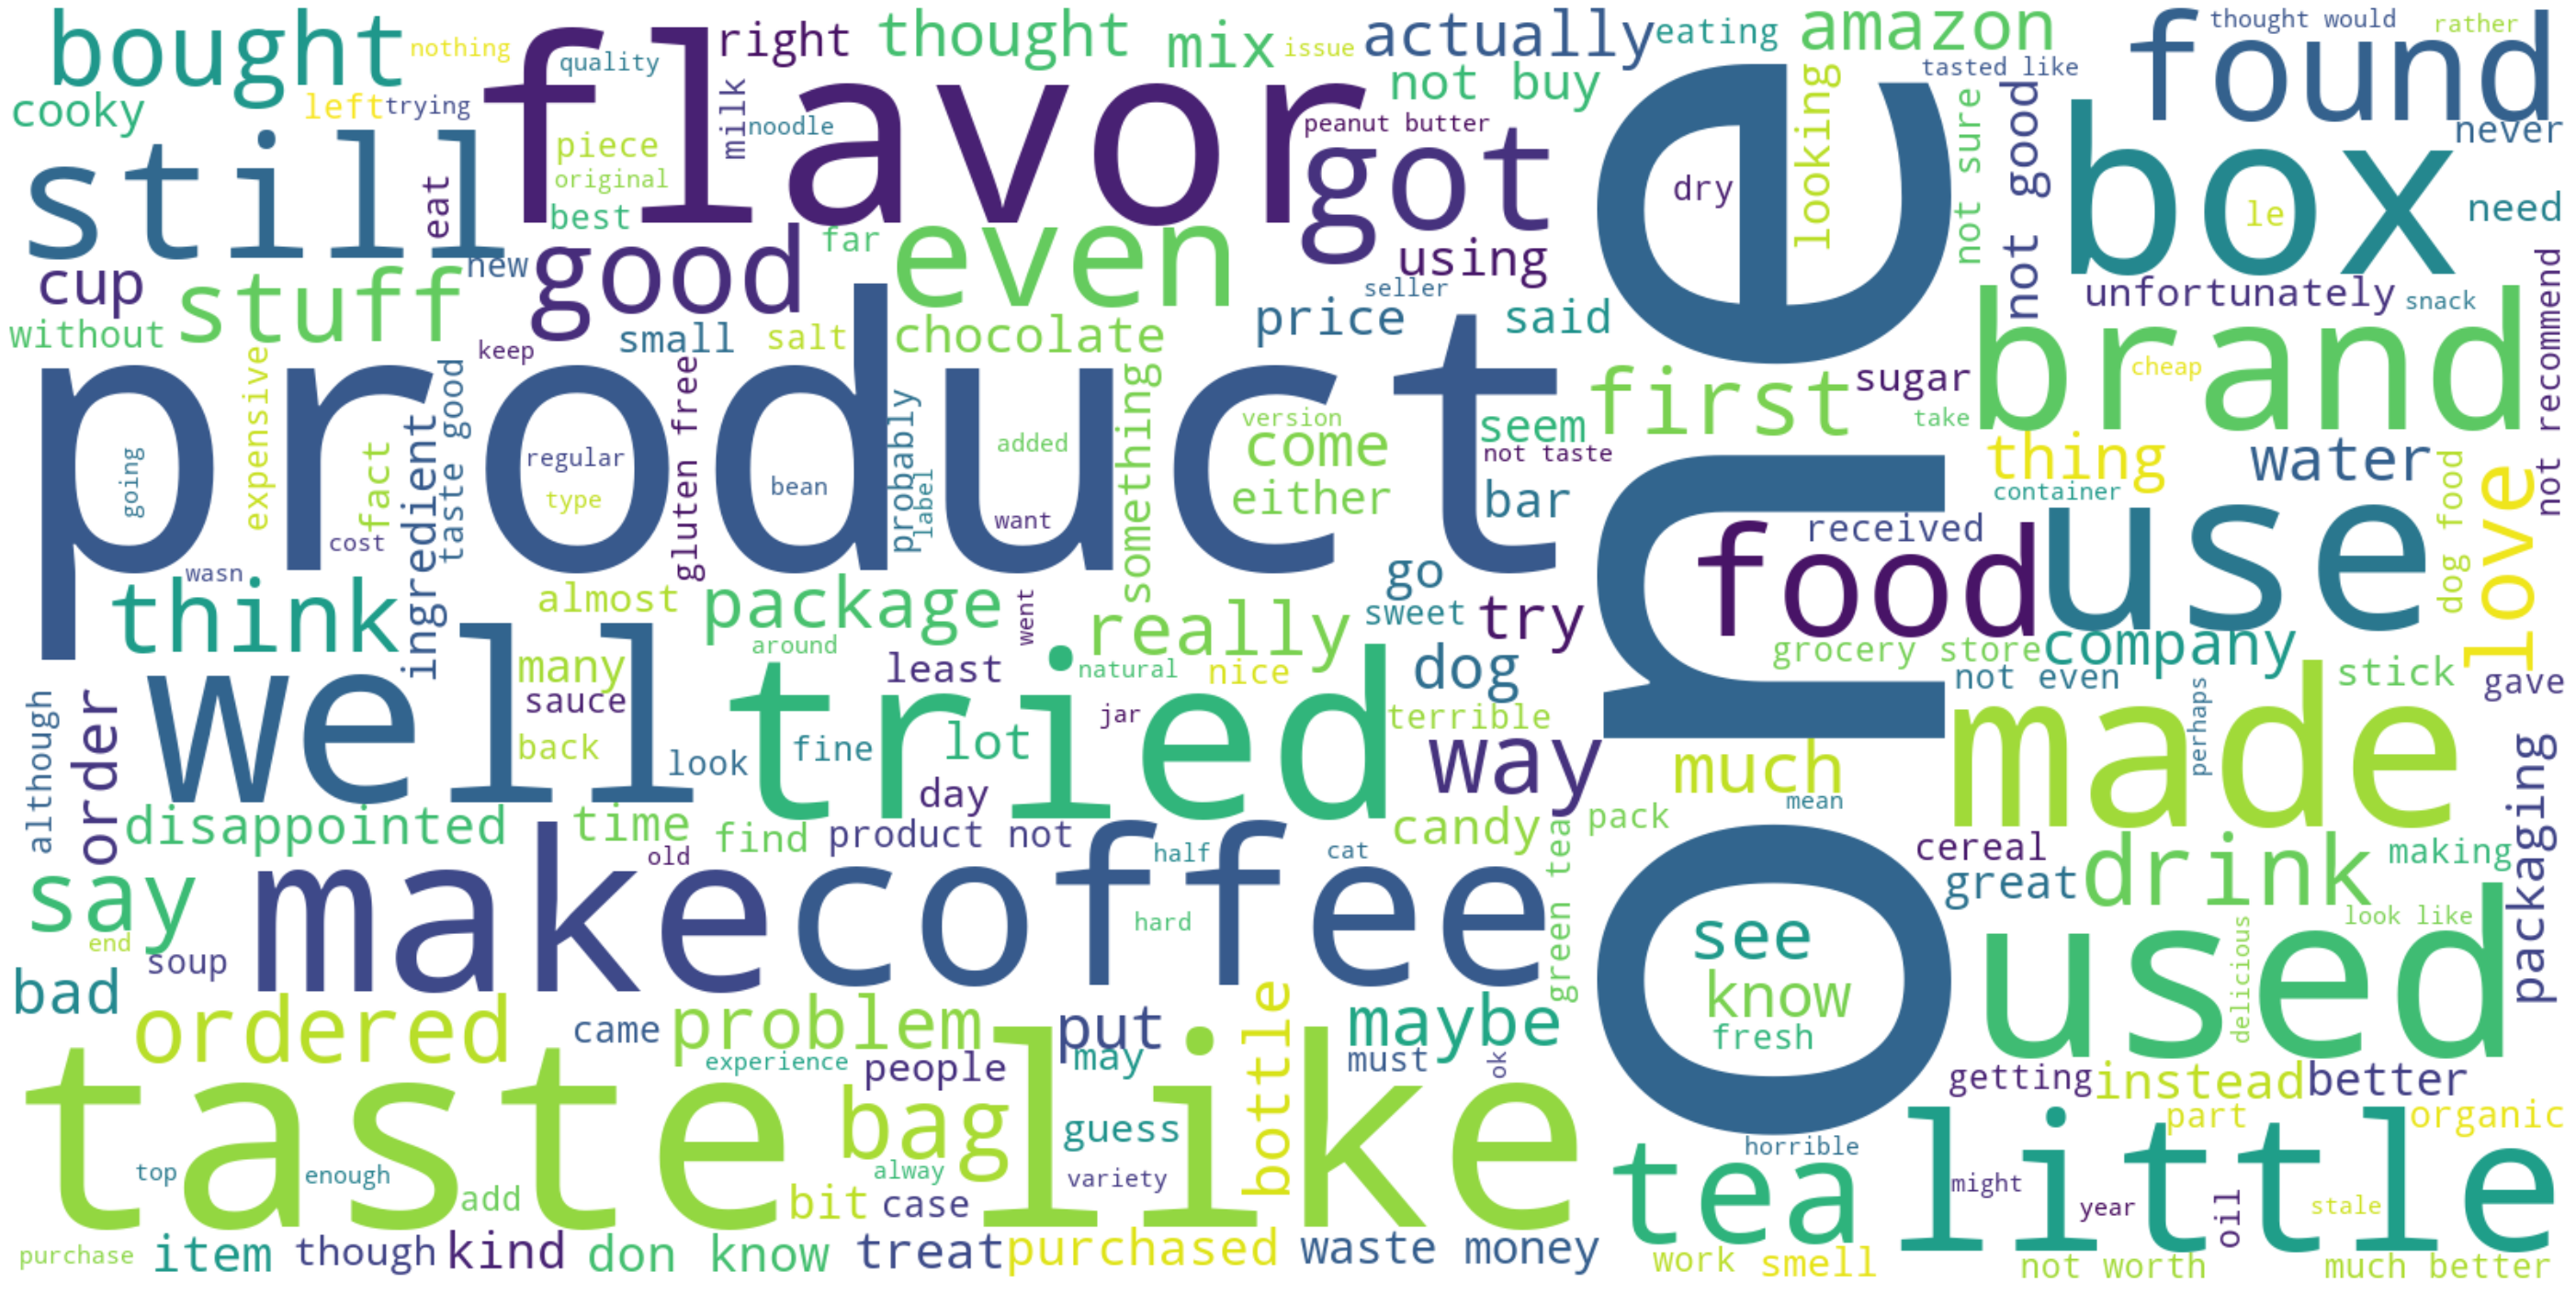

<Figure size 3600x2880 with 0 Axes>

In [164]:
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.rcParams['figure.figsize'] = (50,40)
plt.tight_layout(pad=0)

In [156]:
pos = our_df[our_df['Score'] == 1]
pos

Wordnet_Lemmatized  \
150528                                    [june, saw, charming, group, rose, begin, droop, pepped, chicken, soup, sprinkle, sprinkle, twice, sprinkle, chicken, soup, rice, great, book, teach, child, month, year, repetition, phrase, funny, little, story, accompanying, picture, make, ideal, bedtime, read, isn, nearly, good, sendak, book, like, wild, thing, pierre, boy, didn, care, still, carry, unique, brand, charm, ]   
150506                                                                                                                                                                                                                                                                                                              [fun, way, child, learn, month, year, learn, poem, throughout, school, year, like, handmotions, invent, poem, ]   
150505                                                                                                                                                                                                                        [grew, reading, sendak, book, watching, really, rosie, movie, incorporates, love, son, love, however, miss, hard, cover, version, paperback, seem, kind, flimsy, take, two, hand, keep, page, open, ]   
150504                                                                                                                                                                                                                                                                          [get, movie, sound, track, sing, along, carol, king, great, stuff, whole, extended, family, know, song, heart, quality, kid, storytelling, music, ]   
150503                                                                                                                                                                                                                                                                  [entertaining, rhyming, story, cleaver, catchy, illustration, imaginative, fit, right, however, paperback, somewhat, small, flimsy, opt, bigger, edition, ]   
...                                                                                                                                                                                                                                                                                                                                                                                                                             ...   
193171                                                                                                                                                                                                                                                                                                  [ft, zero, best, sweetener, ever, tried, aftertaste, stomach, issue, bottle, last, forever, get, potent, dose, one, drop, ]   
188388  [try, sauce, believe, start, little, sweet, honey, taste, bud, become, alive, flavor, sweet, onion, garlic, whiskey, mesquite, smoked, flavor, analyzing, flavor, second, get, awesome, habanero, kick, come, back, side, mouth, slowly, rise, heat, stage, hotter, sweet, whiskey, habanero, sauce, way, overwhelming, leaf, bad, taste, mouth, simply, perfect, cant, wait, try, smoked, tennessee, maple, sauce, next, ]   
221794                                                                                                                                                                                                                                                                                                        [bought, hazelnut, paste, nocciola, spread, local, shop, palm, cost, florida, taste, excellent, healthier, nutella, ]   
5702                                                                                                                                                                       

**Word Cloud on Positive Words**

In [161]:
%%time 

yolo = " ".join(txt for txt in pos.Final_Preprocessed_words)
print ("There are {} words in the combination of positive review.".format(len(yolo)))

# Create and generate a word cloud image:
cloud_1 = WordCloud(background_color="white",width=1600, height=800).generate(yolo)

There are 87534159 words in the combination of positive review.
Wall time: 1min


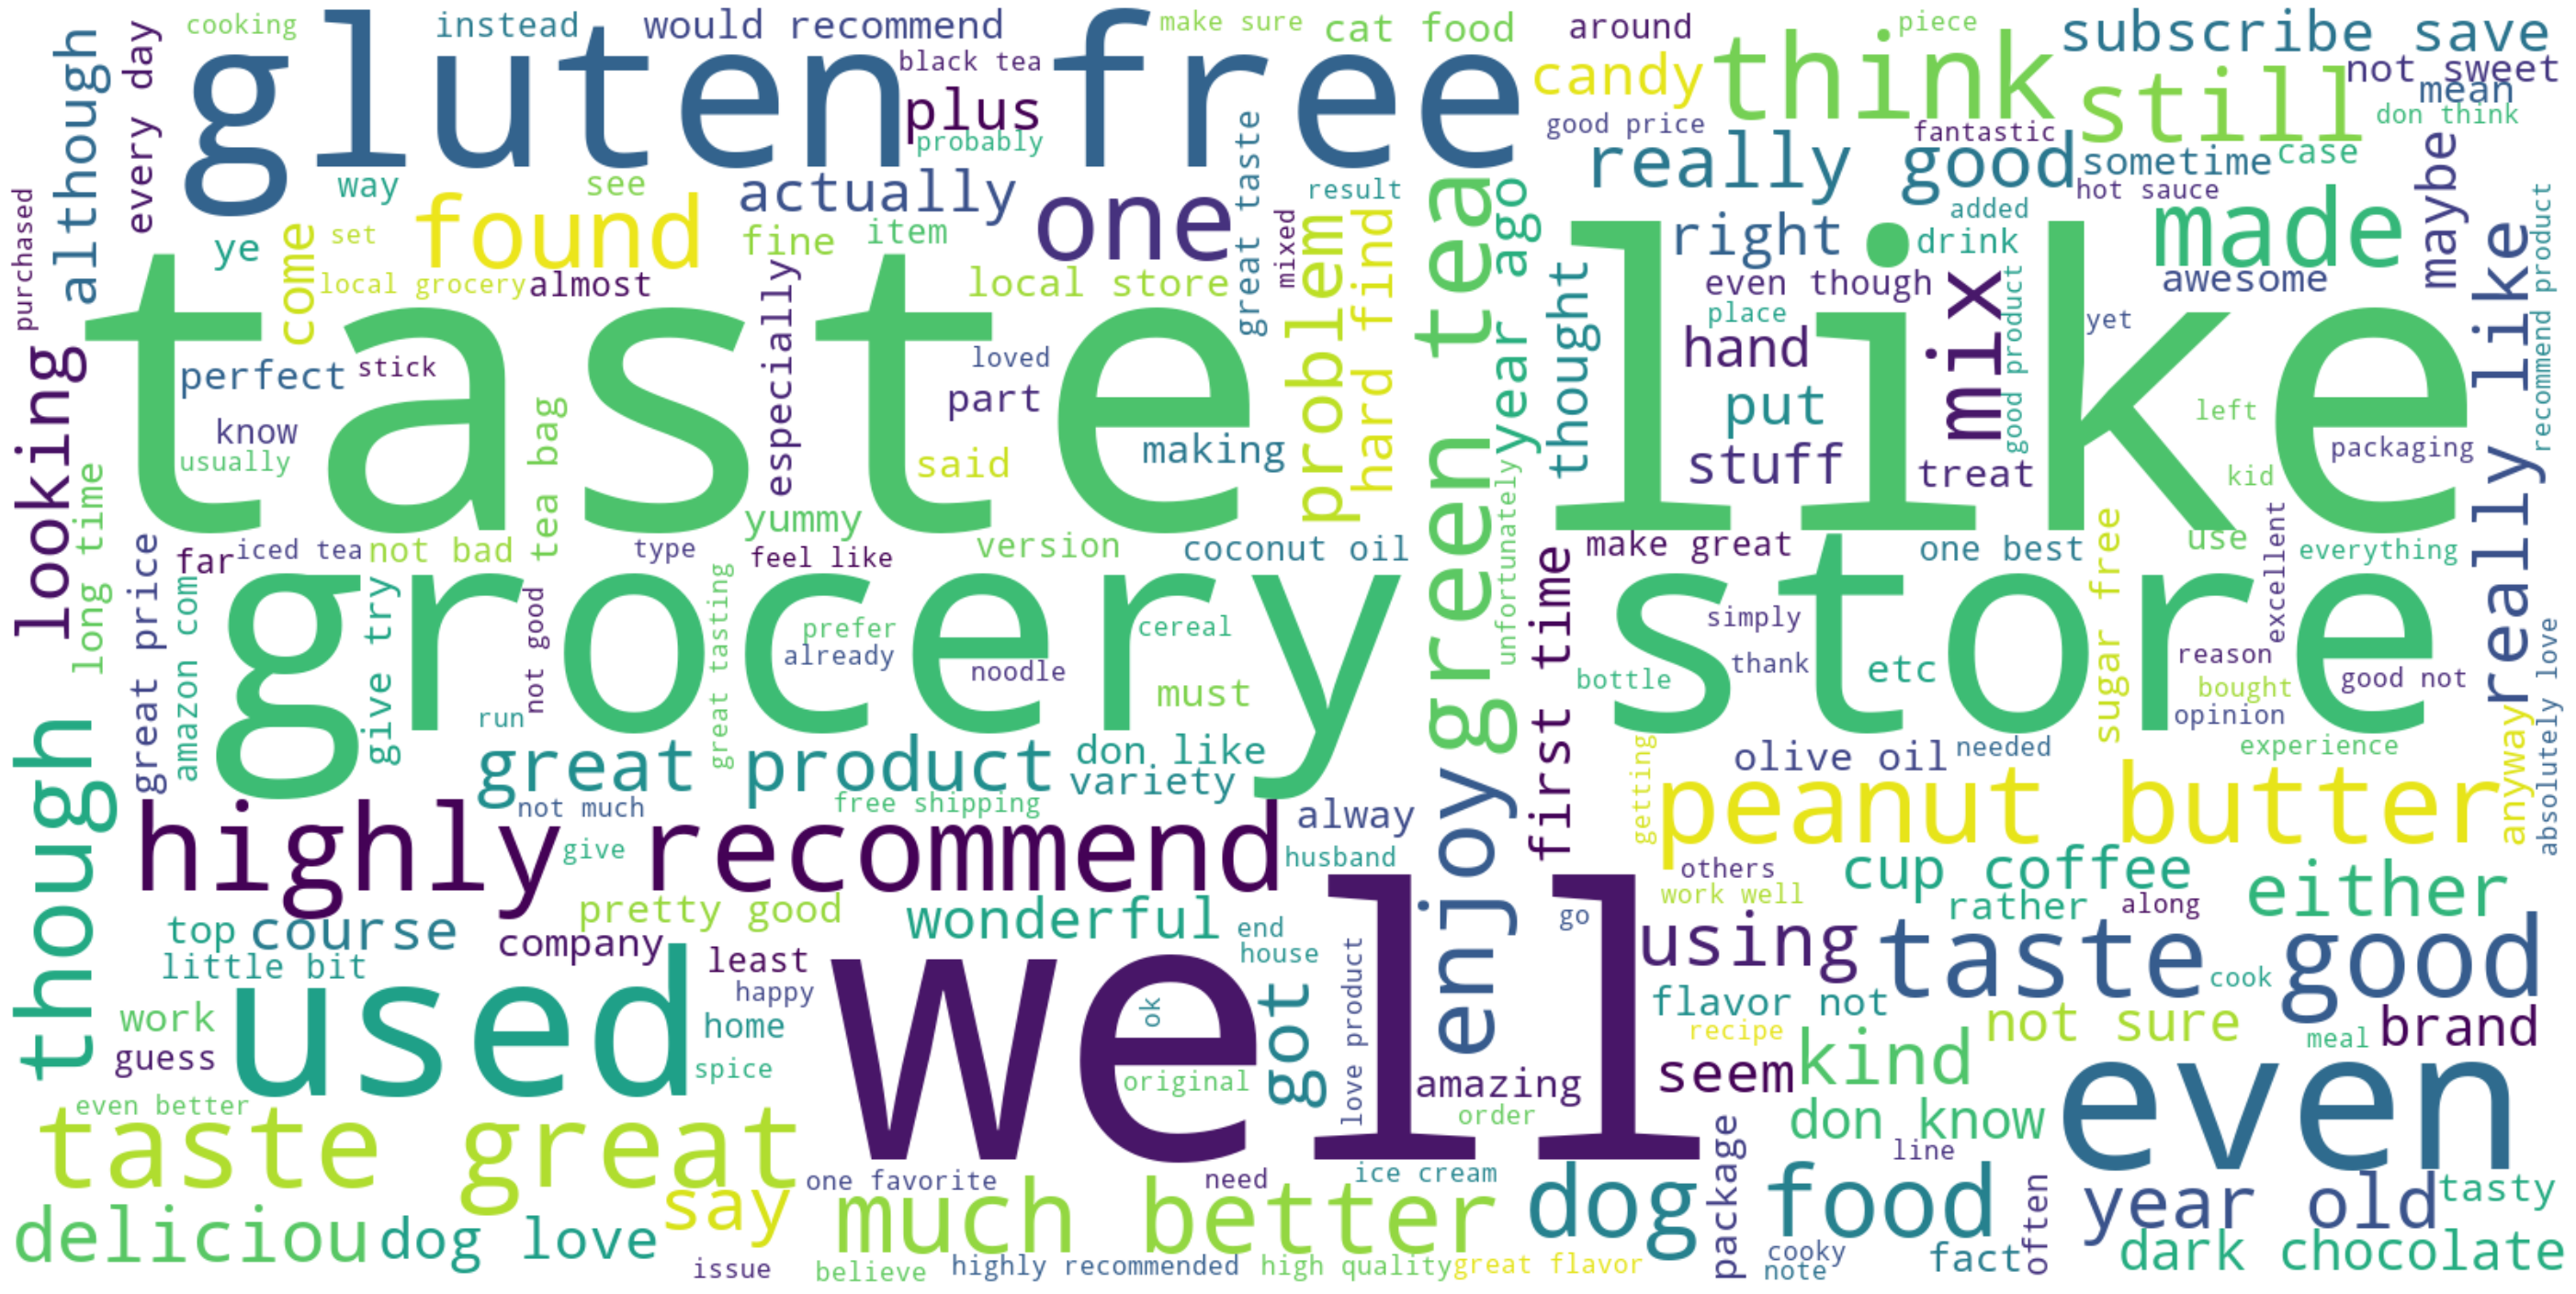

<Figure size 3600x2880 with 0 Axes>

In [169]:
plt.imshow(cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.rcParams['figure.figsize'] = (50,40)
plt.tight_layout(pad=0)